<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/MCTS01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 蒙特卡洛树搜索及实现三子棋游戏

## 双人有限零和顺序游戏
MCTS运行所在的框架/环境是一个游戏，它本身是一个非常抽象和宽泛的概念，因此这里我们只关注一种游戏类型：双人有限零和顺序游戏。这个名词一开始听起来会有些复杂，但是实际上非常简单，现在来让我们将它分解一下：

游戏：意味着我们在一种需要交互的情境中，交互通常会涉及一个或多个角色
有限：表明在任意时间点，角色之间存在的交互方式都是有限的
双人：游戏中只有两个角色
顺序：玩家依次交替进行他们的动作
零和：参与游戏的两方有完全相反的目标，换句话说就是，游戏的任意结束状态双方的收益之和等于零

我们可以很轻松的验证，围棋、国际象棋和井字棋都是双人有限零和顺序游戏：有两位玩家参与，玩家能进行的动作总是有限的，双方的游戏目标是完全相反的（所有游戏的结果之和等于0）。


## 游戏树

游戏树是一种常见的数据结构，其中每一个节点代表游戏的一个确定状态，从一个节点到该节点的一个子节点（如果存在）是一个移动。节点的子节点数目称为分支因子。游戏树的根节点代表游戏的初始状态。游戏树的终端节点是没有子节点的节点，至此游戏结束，无法再进行移动。终端节点的状态也就是游戏的结果（输/赢/平局）。

下面以井字棋游戏为例，形象地来看下什么是游戏树。

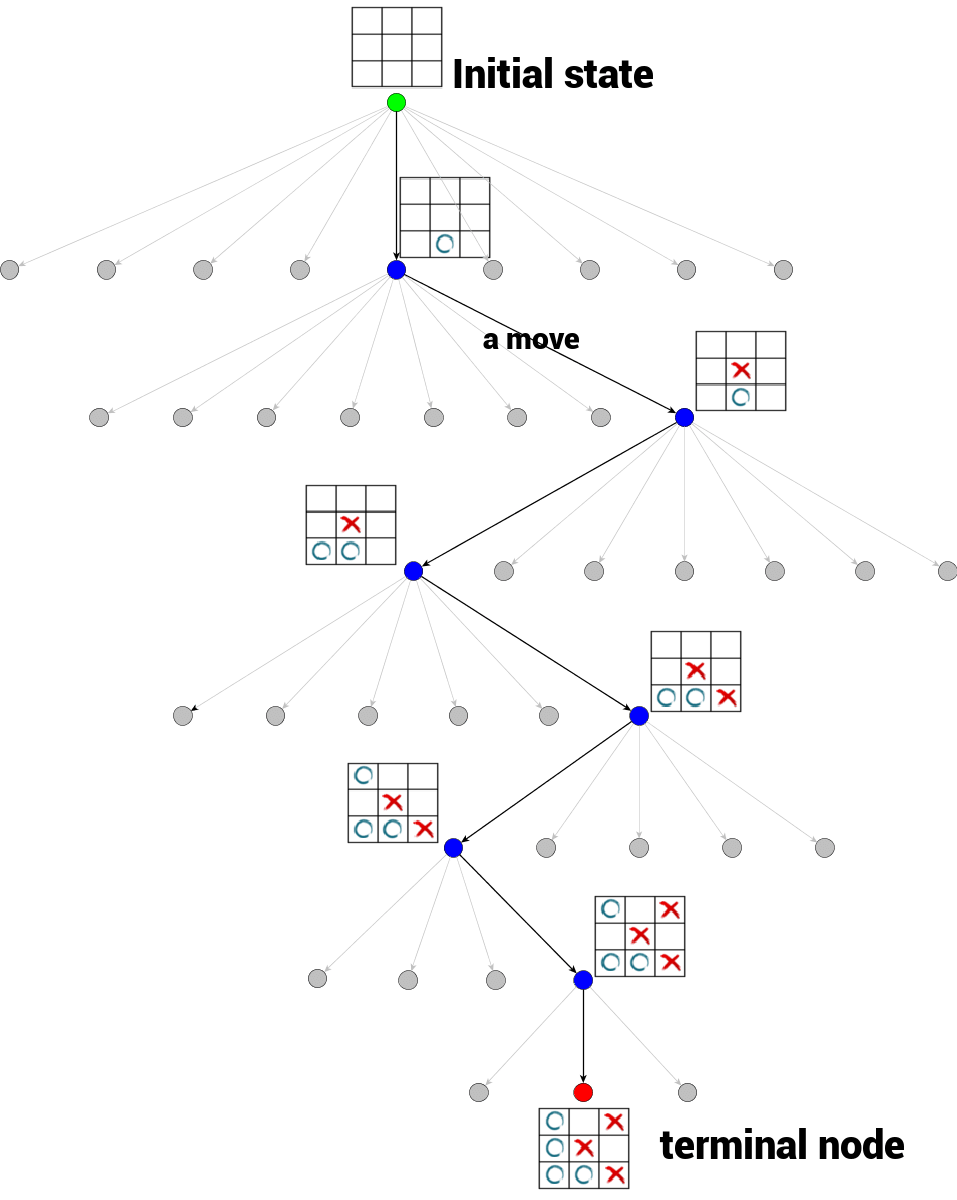

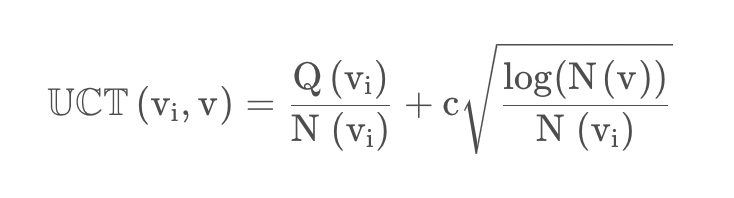

In [1]:
mcts_code = '''
from __future__ import division

import time
import math
import random


#采取随机策略进行动作输出
def randomPolicy(state):
    while not state.isTerminal():
        try:
            action = random.choice(state.getPossibleActions())
        except IndexError:
            raise Exception("Non-terminal state has no possible actions: " + str(state))
        state = state.takeAction(action)
    return state.getReward()


#MCTS树节点
#当前状态state
#是否结束isTerminal
#是否扩展isFullyExpanded
#父亲节点parent
#访问次数numVisits
#总共收益totalReward
#孩子节点children

class treeNode():
    def __init__(self, state, parent):
        self.state = state
        self.isTerminal = state.isTerminal()
        self.isFullyExpanded = self.isTerminal
        self.parent = parent
        self.numVisits = 0
        self.totalReward = 0
        self.children = {}

    def __str__(self):
        s=[]
        s.append("totalReward: %s"%(self.totalReward))
        s.append("numVisits: %d"%(self.numVisits))
        s.append("isTerminal: %s"%(self.isTerminal))
        s.append("possibleActions: %s"%(self.children.keys()))
        return "%s: {%s}"%(self.__class__.__name__, ', '.join(s))

class mcts():
    def __init__(self, timeLimit=None, iterationLimit=None, explorationConstant=1 / math.sqrt(2),
                 rolloutPolicy=randomPolicy):
        if timeLimit != None:
            if iterationLimit != None:
                raise ValueError("Cannot have both a time limit and an iteration limit")
            # time taken for each MCTS search in milliseconds
            self.timeLimit = timeLimit
            self.limitType = 'time'
        else:
            if iterationLimit == None:
                raise ValueError("Must have either a time limit or an iteration limit")
            # number of iterations of the search
            if iterationLimit < 1:
                raise ValueError("Iteration limit must be greater than one")
            self.searchLimit = iterationLimit
            self.limitType = 'iterations'
        self.explorationConstant = explorationConstant
        self.rollout = rolloutPolicy


    def search(self, initialState, needDetails=False):
        self.root = treeNode(initialState, None)

        if self.limitType == 'time':
            timeLimit = time.time() + self.timeLimit / 1000
            while time.time() < timeLimit:
                self.executeRound()
        else:
            for i in range(self.searchLimit):
                self.executeRound()

        bestChild = self.getBestChild(self.root, 0)
        action=(action for action, node in self.root.children.items() if node is bestChild).__next__()
        if needDetails:
            return {"action": action, "expectedReward": bestChild.totalReward / bestChild.numVisits}
        else:
            return action

    #执行一个迭代：选择最优节点-扩展儿子节点-模拟随机决策-结果反向传递
    def executeRound(self):
        """
            execute a selection-expansion-simulation-backpropagation round
        """
        node = self.selectNode(self.root)#选择最优节点
        reward = self.rollout(node.state)#模拟随机决策
        self.backpropogate(node, reward)#结果反向传递

    #选择最优节点
    #如果当前节点已经扩展出子节点，就选择最优节点
    #如果当前节点没有扩展出子节点，就进行节点扩展
    def selectNode(self, node):
        while not node.isTerminal:
            if node.isFullyExpanded:
                node = self.getBestChild(node, self.explorationConstant)
            else:
                return self.expand(node)
        return node

    #扩展儿子节点
    #得到当前状态之下所有可选动作
    #遍历所有可选动作：
    #如果动作不在儿子列表中 添加新节点到儿子列表中 直到添加完所有儿子节点
    def expand(self, node):
        actions = node.state.getPossibleActions()
        for action in actions:
            if action not in node.children:
                newNode = treeNode(node.state.takeAction(action), node)
                node.children[action] = newNode
                if len(actions) == len(node.children):
                    node.isFullyExpanded = True
                return newNode

        raise Exception("Should never reach here")


    #结果反向传递
    #每次反向传递开启，节点访问次数加一
    #节点以及祖先的收益 累加 当前仿真出来的收益
    def backpropogate(self, node, reward):
        while node is not None:
            node.numVisits += 1
            node.totalReward += reward
            node = node.parent

    #UCT计算
    def getBestChild(self, node, explorationValue):
        bestValue = float("-inf")
        bestNodes = []
        for child in node.children.values():
            nodeValue = node.state.getCurrentPlayer() * child.totalReward / child.numVisits + explorationValue * math.sqrt(
                2 * math.log(node.numVisits) / child.numVisits)
            if nodeValue > bestValue:
                bestValue = nodeValue
                bestNodes = [child]
            elif nodeValue == bestValue:
                bestNodes.append(child)
        return random.choice(bestNodes)

'''


path = 'mcts.py'
f = open(path, 'w')
f.write(mcts_code)
f.close()

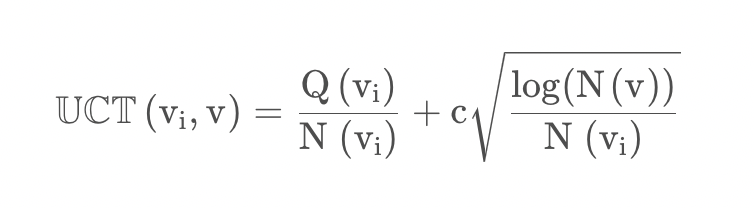

In [2]:
from __future__ import division

from copy import deepcopy
from mcts import mcts
from functools import reduce
import operator


class NaughtsAndCrossesState():
    def __init__(self):
        self.board = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
        self.currentPlayer = 1

    def getCurrentPlayer(self):
        return self.currentPlayer

    #获取接下来可能的落子位置
    def getPossibleActions(self):
        possibleActions = []
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if self.board[i][j] == 0:
                    possibleActions.append(Action(player=self.currentPlayer, x=i, y=j))
        return possibleActions

    def takeAction(self, action):
        newState = deepcopy(self)
        newState.board[action.x][action.y] = action.player
        newState.currentPlayer = self.currentPlayer * -1
        return newState

    #判断当前局面是否结束状态（三列/三行/对角线）
    def isTerminal(self):
        for row in self.board:
            if abs(sum(row)) == 3:
                return True
        for column in list(map(list, zip(*self.board))):
            if abs(sum(column)) == 3:
                return True
        for diagonal in [[self.board[i][i] for i in range(len(self.board))],
                         [self.board[i][len(self.board) - i - 1] for i in range(len(self.board))]]:
            if abs(sum(diagonal)) == 3:
                return True
        return reduce(operator.mul, sum(self.board, []), 1)

    def getReward(self):
        for row in self.board:
            if abs(sum(row)) == 3:
                return sum(row) / 3
        for column in list(map(list, zip(*self.board))):
            if abs(sum(column)) == 3:
                return sum(column) / 3
        for diagonal in [[self.board[i][i] for i in range(len(self.board))],
                         [self.board[i][len(self.board) - i - 1] for i in range(len(self.board))]]:
            if abs(sum(diagonal)) == 3:
                return sum(diagonal) / 3
        return False


class Action():
    def __init__(self, player, x, y):
        self.player = player
        self.x = x
        self.y = y

    def __str__(self):
        return str((self.x, self.y))

    def __repr__(self):
        return str(self)

    def __eq__(self, other):
        return self.__class__ == other.__class__ and self.x == other.x and self.y == other.y and self.player == other.player

    def __hash__(self):
        return hash((self.x, self.y, self.player))

if __name__=="__main__":
    initialState = NaughtsAndCrossesState()
    searcher = mcts(timeLimit=1600)
    action = searcher.search(initialState=initialState)

    print(action)

(1, 1)


In [3]:
mcts_code = '''
from __future__ import division

import time
import math
import random


def randomPolicy(state):
    while not state.isTerminal():
        try:
            action = random.choice(state.getPossibleActions())
        except IndexError:
            raise Exception("Non-terminal state has no possible actions: " + str(state))
        state = state.takeAction(action)
    return state.getReward()


class treeNode():
    def __init__(self, state, parent):
        self.state = state
        self.isTerminal = state.isTerminal()
        self.isFullyExpanded = self.isTerminal
        self.parent = parent
        self.numVisits = 0
        self.totalReward = 0
        self.children = {}


class mcts():
    def __init__(self, timeLimit=None, iterationLimit=None, explorationConstant=1 / math.sqrt(2),
                 rolloutPolicy=randomPolicy):
        if timeLimit != None:
            if iterationLimit != None:
                raise ValueError("Cannot have both a time limit and an iteration limit")
            # time taken for each MCTS search in milliseconds
            self.timeLimit = timeLimit
            self.limitType = 'time'
        else:
            if iterationLimit == None:
                raise ValueError("Must have either a time limit or an iteration limit")
            # number of iterations of the search
            if iterationLimit < 1:
                raise ValueError("Iteration limit must be greater than one")
            self.searchLimit = iterationLimit
            self.limitType = 'iterations'
        self.explorationConstant = explorationConstant
        self.rollout = rolloutPolicy

    def search(self, initialState):
        self.root = treeNode(initialState, None)

        if self.limitType == 'time': #时间限制
            timeLimit = time.time() + self.timeLimit / 1000
            while time.time() < timeLimit:
                self.executeRound()
        else: #次数限制
            for i in range(self.searchLimit):
                self.executeRound()

        bestChild = self.getBestChild(self.root, 0)
        return self.getAction(self.root, bestChild)

    #执行一个迭代：选择最优节点-扩展儿子节点-模拟随机决策-结果反向传递
    def executeRound(self):
        node = self.selectNode(self.root)#选择最优节点
        reward = self.rollout(node.state)#模拟随机决策
        self.backpropogate(node, reward)#结果反向传递

    #选择最优节点
    #如果当前节点已经扩展出子节点，就选择最优节点
    #如果当前节点没有扩展出子节点，就进行节点扩展
    def selectNode(self, node):
        while not node.isTerminal:
            if node.isFullyExpanded:
                node = self.getBestChild(node, self.explorationConstant)
            else:
                return self.expand(node)
        return node

    #扩展儿子节点
    #得到当前状态之下所有可选动作
    #遍历所有可选动作：
    #如果动作不在儿子列表中 添加新节点到儿子列表中 直到添加完所有儿子节点
    def expand(self, node):
        actions = node.state.getPossibleActions()
        for action in actions:
            if action not in node.children:
                newNode = treeNode(node.state.takeAction(action), node) 
                node.children[action] = newNode
                if len(actions) == len(node.children):
                    node.isFullyExpanded = True
                return newNode

        raise Exception("Should never reach here")

    #结果反向传递
    #每次反向传递开启，节点访问次数加一
    #节点以及祖先的收益 累加 当前仿真出来的收益
    def backpropogate(self, node, reward):
        while node is not None:
            node.numVisits += 1
            node.totalReward += reward
            node = node.parent

    #UCT计算
    def getBestChild(self, node, explorationValue):
        bestValue = float("-inf")
        bestNodes = []
        for child in node.children.values():
            nodeValue = child.totalReward / child.numVisits + explorationValue * math.sqrt(
                2 * math.log(node.numVisits) / child.numVisits)
            if nodeValue > bestValue:
                bestValue = nodeValue
                bestNodes = [child]
            elif nodeValue == bestValue:
                bestNodes.append(child)
        return random.choice(bestNodes)

    def getAction(self, root, bestChild):
        for action, node in root.children.items():
            if node is bestChild:
                return action

'''


path = 'mcts_new.py'
f = open(path, 'w')
f.write(mcts_code)
f.close()



In [4]:
from __future__ import division

from copy import deepcopy
from mcts_new import mcts
from functools import reduce
import operator


class NaughtsAndCrossesState(object):
    def __init__(self):
        self.target_num = 3  #最终目标
        self.board_width = 3
        self.board = [[0] * self.board_width for _ in range(self.board_width)]
        self.currentPlayer = 1

    def getPossibleActions(self):
        possibleActions = []
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                if self.board[i][j] == 0:
                    possibleActions.append(Action(player=self.currentPlayer, x=i, y=j))
        return possibleActions

    def takeAction(self, action):
        newState = deepcopy(self)
        newState.board[action.x][action.y] = action.player
        newState.currentPlayer = self.currentPlayer * -1
        return newState

    def isTerminal(self):
        for row in self.board:
            if abs(sum(row)) == self.target_num:
                return True
        for column in list(map(list, zip(*self.board))):
            if abs(sum(column)) == self.target_num:
                return True
        for diagonal in [[self.board[i][i] for i in range(len(self.board))],
                         [self.board[i][len(self.board) - i - 1] for i in range(len(self.board))]]:
            if abs(sum(diagonal)) == self.target_num:
                return True
        return reduce(operator.mul, sum(self.board, []), 1)

    def getReward(self):
        for row in self.board:
            if abs(sum(row)) == self.target_num:
                return sum(row) / self.target_num
        for column in list(map(list, zip(*self.board))):
            if abs(sum(column)) == self.target_num:
                return sum(column) / self.target_num
        for diagonal in [[self.board[i][i] for i in range(len(self.board))],
                         [self.board[i][len(self.board) - i - 1] for i in range(len(self.board))]]:
            if abs(sum(diagonal)) == self.target_num:
                return sum(diagonal) / self.target_num
        return False


class Action():
    def __init__(self, player, x, y):
        self.player = player
        self.x = x
        self.y = y

    def __str__(self):
        return str((self.x, self.y))

    def __repr__(self):
        return str(self)

    def __eq__(self, other):
        return self.__class__ == other.__class__ and self.x == other.x and self.y == other.y and self.player == other.player

    def __hash__(self):
        return hash((self.x, self.y, self.player))


if __name__ == '__main__':
    import numpy as np

    s = NaughtsAndCrossesState()
    tree = mcts(timeLimit=1000)
    while True:
        # 机器下棋
        action = tree.search(initialState=s)
        s = s.takeAction(action)
        print("机器:", action)
        print(np.array(s.board))
        if s.isTerminal():
            print("ai win")
            break
        # 人类下棋
        x, y = list(map(int, input().split()))
        action = Action(-1, x, y)
        s = s.takeAction(action)
        print("人类:", action)
        print(np.array(s.board))
        print(s.isTerminal())
        if s.isTerminal():
            print("human win")
            break

机器: (1, 1)
[[0 0 0]
 [0 1 0]
 [0 0 0]]
2 2
人类: (2, 2)
[[ 0  0  0]
 [ 0  1  0]
 [ 0  0 -1]]
0
机器: (0, 2)
[[ 0  0  1]
 [ 0  1  0]
 [ 0  0 -1]]
2 0
人类: (2, 0)
[[ 0  0  1]
 [ 0  1  0]
 [-1  0 -1]]
0
机器: (1, 0)
[[ 0  0  1]
 [ 1  1  0]
 [-1  0 -1]]
2 1
人类: (2, 1)
[[ 0  0  1]
 [ 1  1  0]
 [-1 -1 -1]]
True
human win


In [5]:
import collections
import numpy as np
import math

class UCTNode():
  def __init__(self, game_state, move, parent=None):
    self.game_state = game_state
    self.move = move
    self.is_expanded = False
    self.parent = parent  # Optional[UCTNode]
    self.children = {}  # Dict[move, UCTNode]
    self.child_priors = np.zeros([362], dtype=np.float32)
    self.child_total_value = np.zeros([362], dtype=np.float32)
    self.child_number_visits = np.zeros([362], dtype=np.float32)

  @property
  def number_visits(self):
    return self.parent.child_number_visits[self.move]

  @number_visits.setter
  def number_visits(self, value):
    self.parent.child_number_visits[self.move] = value

  @property
  def total_value(self):
    return self.parent.child_total_value[self.move]

  @total_value.setter
  def total_value(self, value):
    self.parent.child_total_value[self.move] = value

  def child_Q(self):
    return self.child_total_value / (1 + self.child_number_visits)

  def child_U(self):
    return math.sqrt(self.number_visits) * (
        self.child_priors / (1 + self.child_number_visits))

  def best_child(self):
    return np.argmax(self.child_Q() + self.child_U())

  def select_leaf(self):
    current = self
    while current.is_expanded:
      best_move = current.best_child()
      current = current.maybe_add_child(best_move)
    return current

  def expand(self, child_priors):
    self.is_expanded = True
    self.child_priors = child_priors

  def maybe_add_child(self, move):
    if move not in self.children:
      self.children[move] = UCTNode(
          self.game_state.play(move), move, parent=self)
    return self.children[move]

  def backup(self, value_estimate: float):
    current = self
    while current.parent is not None:
      current.number_visits += 1
      current.total_value += (value_estimate *
        self.game_state.to_play)
      current = current.parent

class DummyNode(object):
  def __init__(self):
    self.parent = None
    self.child_total_value = collections.defaultdict(float)
    self.child_number_visits = collections.defaultdict(float)


def UCT_search(game_state, num_reads):
  root = UCTNode(game_state, move=None, parent=DummyNode())
  for _ in range(num_reads):
    leaf = root.select_leaf()
    child_priors, value_estimate = NeuralNet.evaluate(leaf.game_state)
    leaf.expand(child_priors)
    leaf.backup(value_estimate)
  return np.argmax(root.child_number_visits)


class NeuralNet():
  @classmethod
  def evaluate(self, game_state):
    return np.random.random([362]), np.random.random()

class GameState():
  def __init__(self, to_play=1):
    self.to_play = to_play

  def play(self, move):
    return GameState(-self.to_play)

num_reads = 10000
import time
tick = time.time()
UCT_search(GameState(), num_reads)
tock = time.time()
print("Took %s sec to run %s times" % (tock - tick, num_reads))
import resource
print("Consumed %sB memory" % resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)

Took 0.7374765872955322 sec to run 10000 times
Consumed 177892B memory


In [6]:
import numpy as np
import math

class UCTNode():
  def __init__(self, game_state, parent=None, prior=0):
    self.game_state = game_state
    self.is_expanded = False
    self.parent = parent  # Optional[UCTNode]
    self.children = {}  # Dict[move, UCTNode]
    self.prior = prior  # float
    self.total_value = 0  # float
    self.number_visits = 0  # int

  def Q(self):  # returns float
    return self.total_value / (1 + self.number_visits)

  def U(self):  # returns float
    return (math.sqrt(self.parent.number_visits)
        * self.prior / (1 + self.number_visits))

  def best_child(self):
    return max(self.children.values(),
               key=lambda node: node.Q() + node.U())

  def select_leaf(self):
    current = self
    while current.is_expanded:
      current = current.best_child()
    return current

  def expand(self, child_priors):
    self.is_expanded = True
    for move, prior in enumerate(child_priors):
      self.add_child(move, prior)

  def add_child(self, move, prior):
    self.children[move] = UCTNode(
        self.game_state.play(move), parent=self, prior=prior)

  def backup(self, value_estimate: float):
    current = self
    while current.parent is not None:
      current.number_visits += 1
      current.total_value += (value_estimate *
        self.game_state.to_play)
      current = current.parent

def UCT_search(game_state, num_reads):
  root = UCTNode(game_state)
  for _ in range(num_reads):
    leaf = root.select_leaf()
    child_priors, value_estimate = NeuralNet.evaluate(leaf.game_state)
    leaf.expand(child_priors)
    leaf.backup(value_estimate)
  return max(root.children.items(),
             key=lambda item: item[1].number_visits)


class NeuralNet():
  @classmethod
  def evaluate(self, game_state):
    return np.random.random([362]), np.random.random()

class GameState():
  def __init__(self, to_play=1):
    self.to_play = to_play

  def play(self, move):
    return GameState(-self.to_play)

num_reads = 10000
import time
tick = time.time()
UCT_search(GameState(), num_reads)
tock = time.time()
print("Took %s sec to run %s times" % (tock - tick, num_reads))
import resource
print("Consumed %sB memory" % resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)

Took 28.982442378997803 sec to run 10000 times
Consumed 2915184B memory
